Set up environment

In [1]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [2]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from eGLM_model import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn
from get_pearson_fc_wci import get_pearson_fc_wci
from get_multreg_fc_wci import get_multreg_fc_wci

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [3]:
num_sims = 10
networks = np.ndarray(num_sims, dtype=object)

In [4]:
for i in range(num_sims):
    sim_args = copy(default_args)
    sim_args.update({'hubnetwork_dsity': .5,
                'outnetwork_dsity':.3, 
                'innetwork_dsity': .60,})
    W = generateSynapticNetwork(generateStructuralNetwork(sim_args))
    sim_args.update({'W': W,
                'noise': 1, 
                'noise_scale': 1,
                'Tmax': 1500})
    networks[i] = sim_args

# Generate time series

## Resting

Resting data in this case is only noise not an AR(1) process.

In [5]:
rest_data = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    sim_args = networks[i]
    rest_data[i], _ = networkModel(sim_args['W'], args_dict=sim_args)

# Compute FC connectivity matrices

## Pearson

### Lag 0

In [6]:
pearson_fcs = np.ndarray(num_sims, dtype=object)
pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    pearson_fcs[i], pearson_fcs_lb[i], pearson_fcs_ub[i], pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i])

### Lag 1

In [7]:
lag_pearson_fcs = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    lag_pearson_fcs[i], lag_pearson_fcs_lb[i], lag_pearson_fcs_ub[i], lag_pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i], lag = 1)

## Multiple regression

FC estimated by using the [multiple regression used by Cole et al.](https://github.com/ColeLab/ActflowToolbox/blob/master/connectivity_estimation/multregconn.py) expanded to add confidence intervals and rmse [here](https://github.com/zenkavi/NeuralMassModels/blob/master/helpers/multregconn.py).

### Lag = 0

In [8]:
mreg_fcs = np.ndarray(num_sims, dtype=object)
mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    mreg_fcs[i], mreg_fcs_lb[i], mreg_fcs_ub[i], mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i])

### Lag = 1

In [9]:
lag_mreg_fcs = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    lag_mreg_fcs[i], lag_mreg_fcs_lb[i], lag_mreg_fcs_ub[i], lag_mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i], lag=1)

# Summarise results

Text(0.5, 1.0, 'MReg lag = 1')

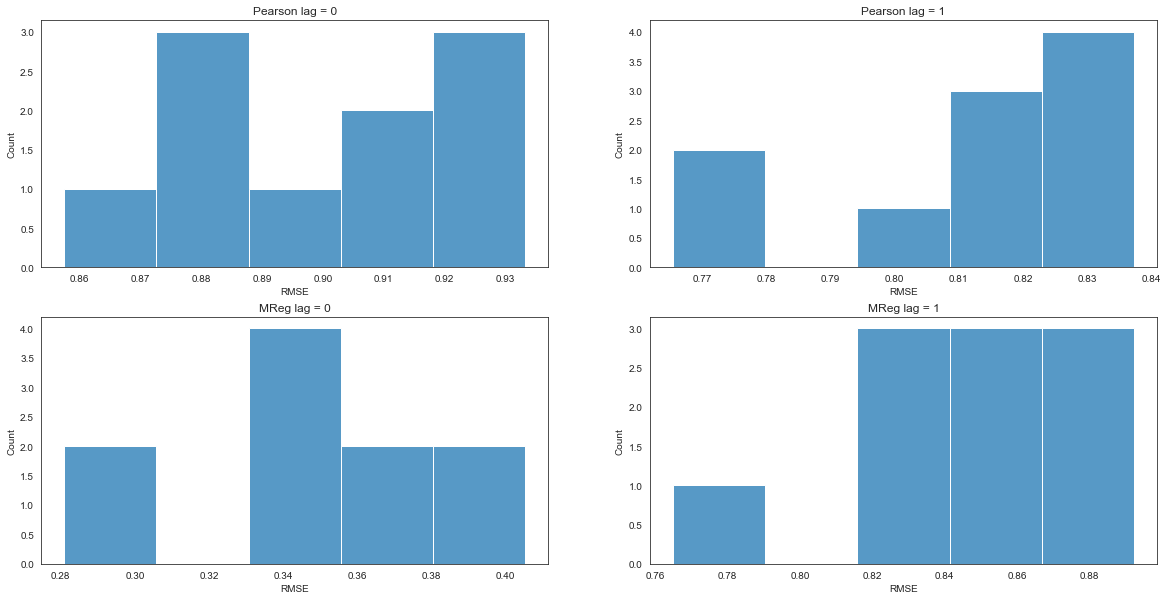

In [24]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 10
fig, a = plt.subplots(2, 2)

rmses = [pearson_fcs_rmse, lag_pearson_fcs_rmse, mreg_fcs_rmse, lag_mreg_fcs_rmse]

for i, cur_rmse in enumerate(rmses):
    sns.histplot(cur_rmse, ax = a.flatten()[i])
    a.flatten()[i].set_xlabel("RMSE")
    
a.flatten()[0].set_title("Pearson lag = 0")
a.flatten()[1].set_title("Pearson lag = 1")
a.flatten()[2].set_title("MReg lag = 0")
a.flatten()[3].set_title("MReg lag = 1")

ValueError: 'x' and 'y' must have the same size

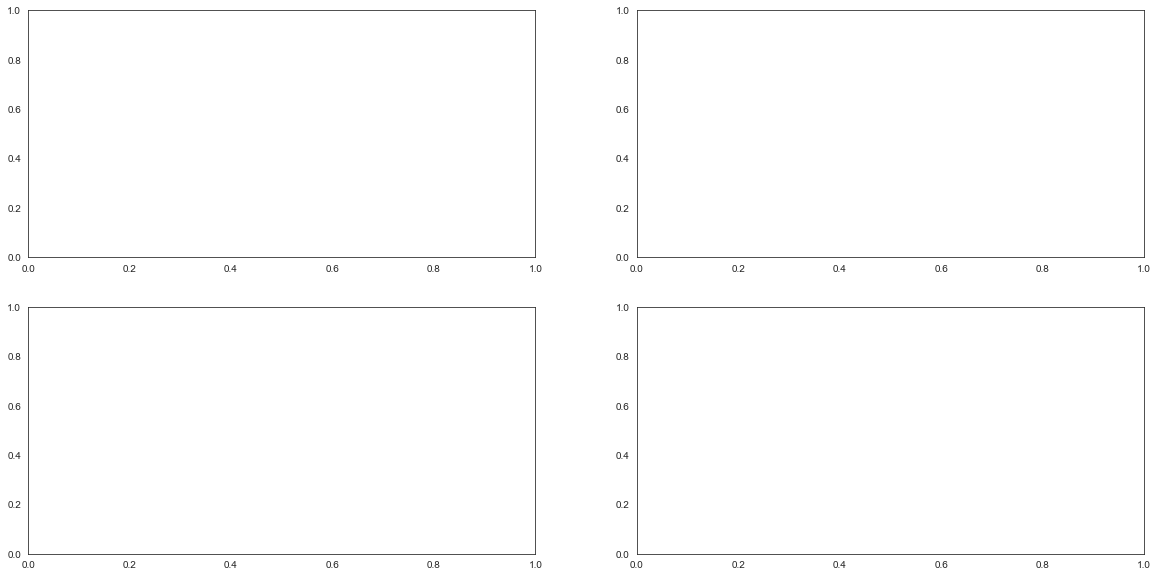

In [25]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 10
fig, a = plt.subplots(2, 2)

fcs = [pearson_fcs, lag_pearson_fcs, mreg_fcs, lag_mreg_fcs]
lbs = [pearson_fcs_lb, lag_pearson_fcs_lb, mreg_fcs_lb, lag_mreg_fcs_lb]
ubs = [pearson_fcs_ub, lag_pearson_fcs_ub, mreg_fcs_ub, lag_mreg_fcs_ub]


for i in range(num_sims):
    for j in range(len(fcs)):
        le = fcs[j][i] - lbs[i]
        ue = ubs[i] - fcs[i]
        a.flatten()[i].errorbar(x = networks[i]['W'].flatten(), y = fcs[i].flatten(), yerr = np.array([le.flatten(), ue.flatten()]), fmt='o', color="black")
        a.flatten()[i].set_xlabel("True connectivity")
        a.flatten()[i].set_ylabel("Functional connectivity")
        a.flatten()[i].axline([0, 0], [1, 1])
    
a.flatten()[0].set_title("Pearson lag = 0")
a.flatten()[1].set_title("Pearson lag = 1")
a.flatten()[2].set_title("MReg lag = 0")
a.flatten()[3].set_title("MReg lag = 1")

In [26]:
networks[i]['W'].flatten()

array([-0.48900987,  0.        ,  0.        ,  0.        , -0.4642301 ,
        0.        ,  0.        ,  0.        , -0.50091224])

In [33]:
fcs

[array([array([[ 1.        ,  0.02500299, -0.04176099],
        [ 0.02500299,  1.        , -0.00475427],
        [-0.04176099, -0.00475427,  1.        ]]),
        array([[1.        , 0.24625202, 0.28842039],
        [0.24625202, 1.        , 0.09255697],
        [0.28842039, 0.09255697, 1.        ]]),
        array([[1.        , 0.35731293, 0.33223651],
        [0.35731293, 1.        , 0.24727483],
        [0.33223651, 0.24727483, 1.        ]]),
        array([[1.        , 0.3375853 , 0.39570308],
        [0.3375853 , 1.        , 0.39617793],
        [0.39570308, 0.39617793, 1.        ]]),
        array([[1.        , 0.36911642, 0.27910435],
        [0.36911642, 1.        , 0.06145846],
        [0.27910435, 0.06145846, 1.        ]]),
        array([[1.        , 0.60522546, 0.60578877],
        [0.60522546, 1.        , 0.68084832],
        [0.60578877, 0.68084832, 1.        ]]),
        array([[ 1.00000000e+00,  2.13552451e-02,  7.17034305e-01],
        [ 2.13552451e-02,  1.00000000e+00